In [163]:
%load_ext autoreload
%autoreload 2

from joblib import Parallel, delayed
import multiprocessing

from tqdm import tqdm, tqdm_notebook
from IPython.display import display
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import json
import pickle
import os
import sys
sys.path.append('..')
from helper.orderbook_trader import OrderbookTradingSimulator
from helper.manage_orderbooks import *
from helper.evaluation import evaluate, plot_evaluation_costs
from helper.general_helpers import add_features_to_orderbooks, load_and_preprocess_historyfiles

from agents.BatchTree_Agent import RLAgent_BatchTree
from agents.QTable_Agent import QTable_Agent

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load pretrained Agents

In [164]:
folder = 'trainedAgents'
agent_files = [f for f in os.listdir(folder) if f.endswith('.json')]
agent_files = [f for f in agent_files if "Dec" in f]
agent_files

['VolTimeDir_Dec0:96_I4.json',
 'VolTime_Dec0:96_I8.json',
 'VolTime_Dec0:96_I4.json',
 'VolTime_Dec0:96_I2.json']

In [165]:
agent_collection = {}
try:
    agent_collection
except NameError:
    agent_collection = {}
    
for elem in agent_files:
    name = elem[:-5]
    agent_collection[name] = QTable_Agent.load(infile_agent=os.path.join(folder, elem),
                                               infile_samples=os.path.join(folder, elem))
print("agent_collection contains {} elements:\n{}".format(len(agent_collection), list(agent_collection.keys())))

agent_collection contains 4 elements:
['VolTimeDir_Dec0:96_I4', 'VolTime_Dec0:96_I8', 'VolTime_Dec0:96_I4', 'VolTime_Dec0:96_I2']


-2.0


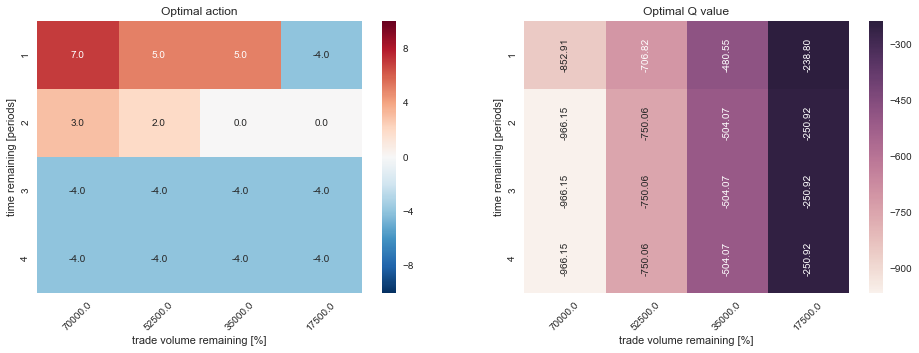

-1.0


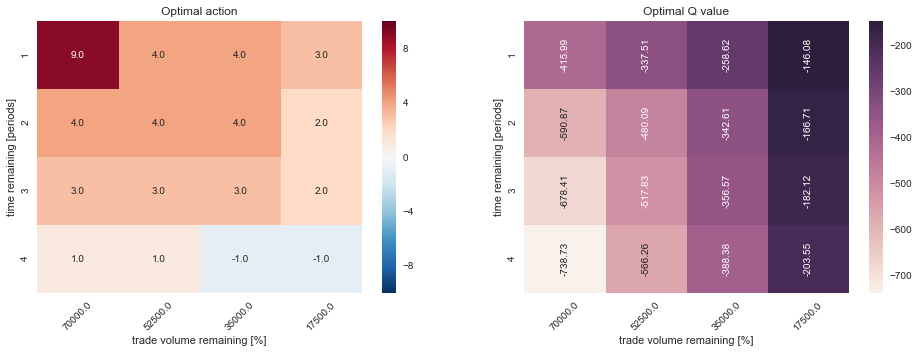

0.0


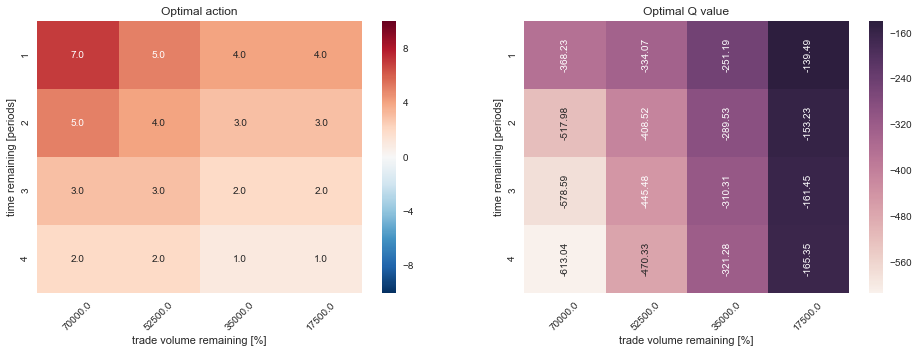

1.0


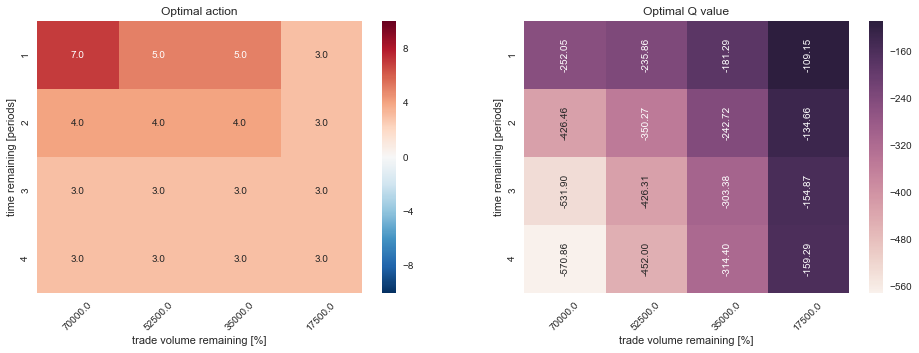

2.0


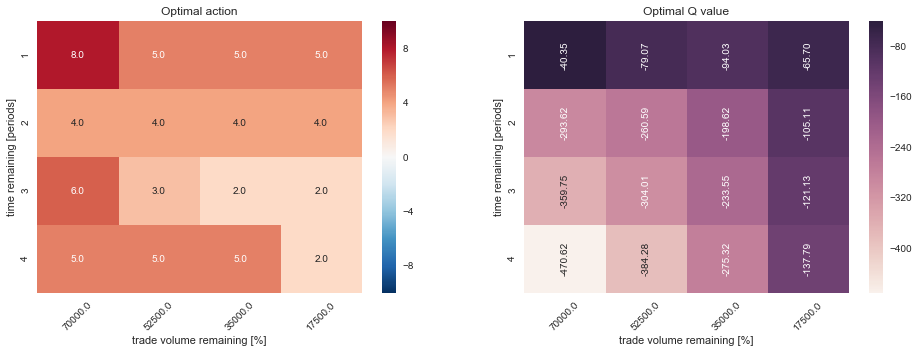

In [193]:
for d in [-2.0, -1., 0., 1., 2.]:
    print(d)
    agent_collection['VolTimeDir_Dec0:96_I4'].heatmap_Q(extra_variables={'direction': d})

VolTime_Dec0:96_I8
4
[ 70000.  61250.  52500.  43750.  35000.  26250.  17500.   8750.]


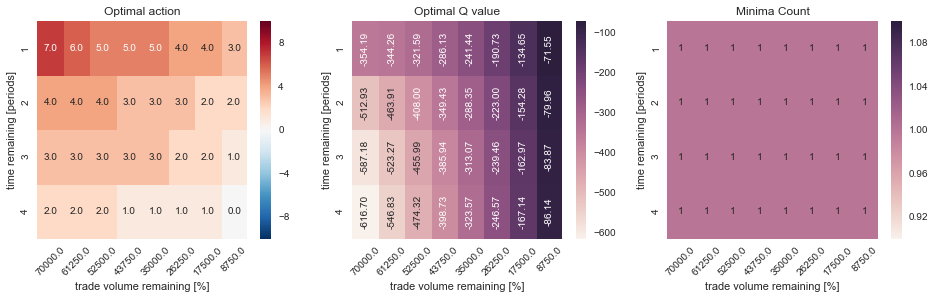

VolTime_Dec0:96_I4
4
[ 70000.  52500.  35000.  17500.]


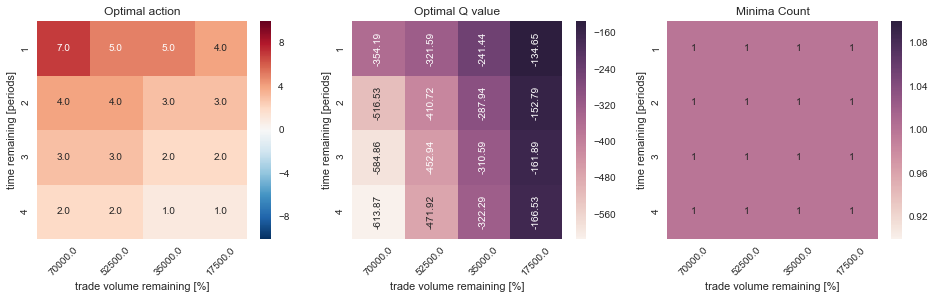

VolTime_Dec0:96_I2
4
[ 70000.  35000.]


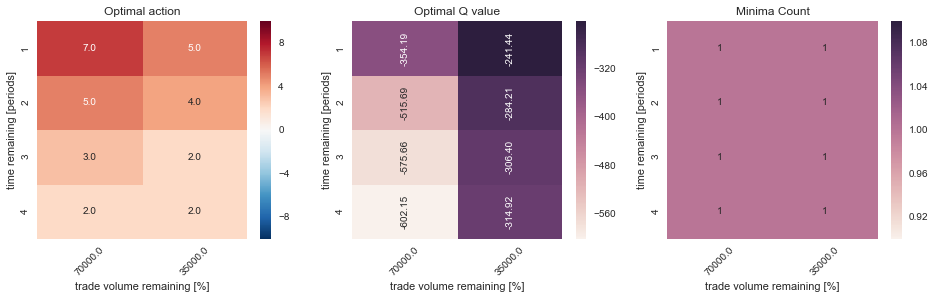

In [87]:
for name in list(agent_collection.keys())[:]:
    print(name)
    agent = agent_collection[name]
    print(agent.T)
    print(agent.volumes)
    agent.heatmap_Q(show_minima_count=True)

In [5]:
### Load data

In [30]:
histfiles = [
    "../../../../data/history/history_2016-11_USDT_BTC.csv",
    "../../../../data/history/history_2016-12_USDT_BTC.csv",
    "../../../../data/history/history_2017-01_USDT_BTC.csv",
    "../../../../data/history/history_2017-02_USDT_BTC.csv",
]

hist = load_and_preprocess_historyfiles(histfiles)

hist['future15_disc'] = pd.cut(hist.future15, bins=[-np.inf, -0.005, -0.001, 0.001, 0.005, np.inf], labels=False)
hist['future30_disc'] = pd.cut(hist.future30, bins=[-np.inf, -0.005, -0.001, 0.001, 0.005, np.inf], labels=False)
hist['future45_disc'] = pd.cut(hist.future45, bins=[-np.inf, -0.005, -0.001, 0.001, 0.005, np.inf], labels=False)
hist['spread_disc'] = pd.cut(hist.spread, bins=[0, 1, 2, np.inf], labels=False)
# display(hist.iloc[1021:1025,:])

In [166]:
data = pickle.load( open( 'cached_windows/tradingwindows_1611_USTD_BTC_20.p', "rb" ) )
print(len(data))
num_cores = multiprocessing.cpu_count()
data = Parallel(n_jobs=num_cores, verbose=10)(delayed(add_features_to_orderbooks)(orderbooks=window, hist=hist) 
                                                 for window in data[:])
print(len(data))

20


[Parallel(n_jobs=24)]: Done   3 out of  20 | elapsed:    0.9s remaining:    5.1s
[Parallel(n_jobs=24)]: Done   6 out of  20 | elapsed:    1.6s remaining:    3.6s
[Parallel(n_jobs=24)]: Done   9 out of  20 | elapsed:    2.3s remaining:    2.8s
[Parallel(n_jobs=24)]: Done  12 out of  20 | elapsed:    2.8s remaining:    1.8s
[Parallel(n_jobs=24)]: Done  15 out of  20 | elapsed:    3.4s remaining:    1.1s
[Parallel(n_jobs=24)]: Done  18 out of  20 | elapsed:    4.0s remaining:    0.4s
[Parallel(n_jobs=24)]: Done  20 out of  20 | elapsed:    4.4s finished


20


In [167]:
data[0][0].features

{'direction': 0.0,
 'future15': -3.2461503485237131e-08,
 'future15_disc': 2.0,
 'future30': -0.00063930325684025124,
 'future30_disc': 2.0,
 'future45': -0.0025756666407984463,
 'future45_disc': 1.0,
 'spread': 0.4509970000000294,
 'spread_disc': 0}

In [168]:
data_dec = pickle.load( open( '/home/axel/notebooks/orderbook_agent/orderbook_agent/cached_windows/obs_2016-12_USDT_BTC_maxVol100.p', "rb" ) )
print(len(data_dec))
num_cores = multiprocessing.cpu_count()
data_dec = Parallel(n_jobs=num_cores, verbose=10)(delayed(add_features_to_orderbooks)(orderbooks=window, hist=hist) 
                                                 for window in data_dec[:200])
print(len(data_dec))

743


[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=24)]: Done  13 tasks      | elapsed:    3.1s
[Parallel(n_jobs=24)]: Done  24 tasks      | elapsed:    5.4s
[Parallel(n_jobs=24)]: Done  37 tasks      | elapsed:    8.1s
[Parallel(n_jobs=24)]: Done  50 tasks      | elapsed:   10.5s
[Parallel(n_jobs=24)]: Done  65 tasks      | elapsed:   13.3s
[Parallel(n_jobs=24)]: Done  80 tasks      | elapsed:   16.4s
[Parallel(n_jobs=24)]: Done  97 tasks      | elapsed:   19.7s
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:   23.0s
[Parallel(n_jobs=24)]: Done 133 tasks      | elapsed:   26.9s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:   32.1s
[Parallel(n_jobs=24)]: Done 174 out of 200 | elapsed:   36.0s remaining:    5.4s
[Parallel(n_jobs=24)]: Done 195 out of 200 | elapsed:   40.0s remaining:    1.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:   41.0s finished


200


### Evaluate

Start parallel evalutions of 8 strategies over 20 tradingperiods. (num_cores=24)


[Parallel(n_jobs=24)]: Done   3 out of  20 | elapsed:    6.9s remaining:   39.1s
[Parallel(n_jobs=24)]: Done   8 out of  20 | elapsed:    7.9s remaining:   11.9s
[Parallel(n_jobs=24)]: Done  13 out of  20 | elapsed:    9.4s remaining:    5.1s
[Parallel(n_jobs=24)]: Done  18 out of  20 | elapsed:   12.3s remaining:    1.4s
[Parallel(n_jobs=24)]: Done  20 out of  20 | elapsed:   13.0s finished


,VolTime_Dec0:96_I8,VolTimeDir_Dec0:96_I4,VolTime_Dec0:96_I4,VolTime_Dec0:96_I2,4,5,6,7
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,220.955628,180.842948,221.547337,218.997112,257.632763,251.008681,247.343409,264.647459
std,204.461218,169.465622,206.710064,202.132163,362.278840,309.424961,251.480629,220.091040
min,27.464142,-47.194919,33.412007,33.412007,8.394920,24.676496,94.524332,117.983001
25%,100.875580,82.056268,101.506556,97.373509,106.979827,118.267090,138.271384,163.023507
50%,163.116084,144.916867,163.116084,162.971930,162.883651,185.252361,194.550876,224.010282
75%,237.149634,227.039200,237.149634,238.426256,214.275733,247.862340,226.041547,263.957144
max,888.510275,705.738243,888.510275,888.510275,1696.797574,1499.715791,1268.307361,1156.598823


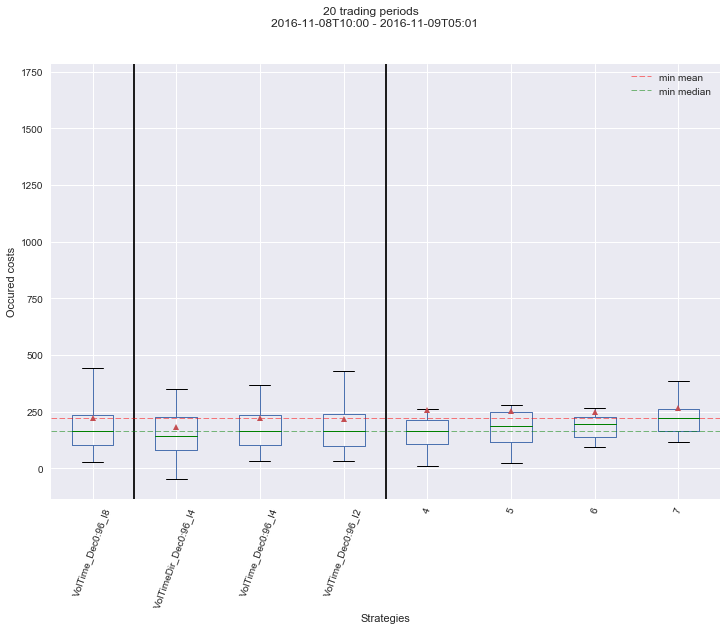

In [171]:
costs = None
baseline = 'VolTime_Dec0:96_I8'
#baseline = list(agent_collection.keys())[0]
costs, slippage = evaluate(
    testdata=data[:],
    agents=agent_collection,
    baseline=baseline,
    evaluate_actions=[4, 5, 6, 7],
    costs=costs,
    verbose=False
)

# display(costs.describe())
# plot_evaluation_costs(costs, hline=baseline)
display(slippage.describe())
plot_evaluation_costs(slippage, hline=baseline, showfliers=True)

In [172]:
slippage

,VolTime_Dec0:96_I8,VolTimeDir_Dec0:96_I4,VolTime_Dec0:96_I4,VolTime_Dec0:96_I2,4,5,6,7
2016-11-08T10:00,53.468760,36.652548,36.652548,59.951984,95.152755,119.167243,125.656871,136.920106
2016-11-08T11:01,132.970311,98.261807,132.977392,118.856782,107.674170,109.581669,114.450859,135.211992
2016-11-08T12:01,87.210660,85.961724,85.961724,90.314516,108.301733,182.806485,191.873765,229.607304
2016-11-08T13:01,369.699505,348.756888,369.699505,369.699505,262.515708,231.487106,202.594267,233.189139
2016-11-08T14:01,519.538613,449.454229,519.538613,499.680683,582.543152,480.004400,423.497500,387.513727
2016-11-08T15:01,234.270561,234.270561,234.270561,234.270561,181.302782,187.698237,195.439234,266.064956
2016-11-08T16:01,27.464142,-47.194919,34.435148,55.675301,104.896798,115.566630,131.436889,155.455035
2016-11-08T17:01,208.139814,211.239884,211.239884,211.239884,207.604953,245.274118,260.730542,263.254540
2016-11-08T18:01,245.786852,245.786852,245.786852,250.893342,226.199089,257.453035,263.437643,272.850695
2016-11-08T19:01,225.275951,166.295451,225.275951,223.195935,195.012743,205.801228,214.478548,250.955259


Start parallel evalutions of 5 strategies over 96 tradingperiods. (num_cores=24)


[Parallel(n_jobs=24)]: Done  24 tasks      | elapsed:   14.0s
[Parallel(n_jobs=24)]: Done  69 out of  96 | elapsed:   31.1s remaining:   12.2s
[Parallel(n_jobs=24)]: Done  89 out of  96 | elapsed:   35.8s remaining:    2.8s
[Parallel(n_jobs=24)]: Done  96 out of  96 | elapsed:   38.9s finished


,VolTime_Dec0:96_I8,VolTimeDir_Dec0:96_I4,VolTime_Dec0:96_I4,VolTime_Dec0:96_I2,5
count,96.000000,96.000000,96.000000,96.000000,96.000000
mean,212.464996,199.243636,211.911594,211.649856,221.482503
std,188.203800,172.171381,188.138959,180.117929,171.477203
min,-50.128093,-140.635919,-50.128093,-50.128093,24.831369
25%,83.453518,83.933159,81.697333,84.481723,147.222773
50%,176.254845,177.009721,175.597924,181.361860,192.928586
75%,258.868206,261.803170,261.920441,263.879881,242.761075
max,956.846346,813.517981,956.846346,949.869892,1105.577957


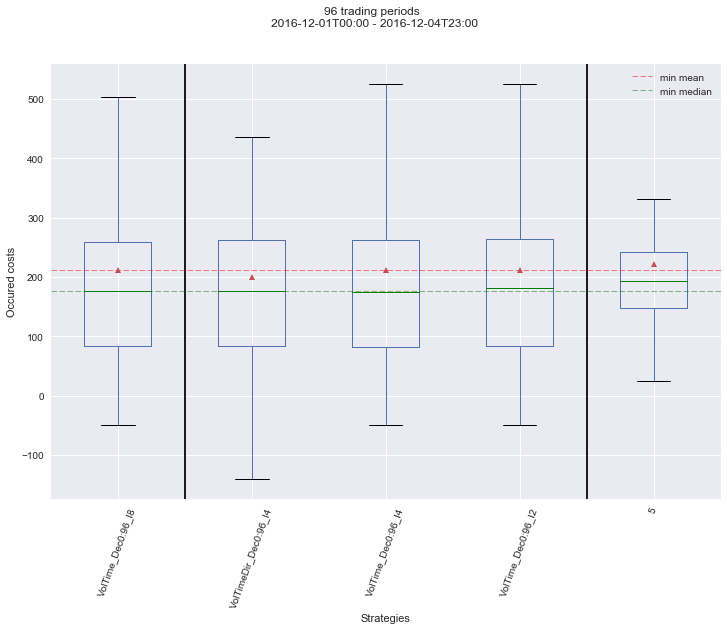

In [175]:
costs = None
baseline = 'VolTime_Dec0:96_I8'
costs, slippage = evaluate(
    testdata=data_dec[:96],
    agents=agent_collection,
    baseline=baseline,
    evaluate_actions=[5],
    costs=costs,
    verbose=False
)

# display(costs.describe())
# plot_evaluation_costs(costs, hline=baseline)
display(slippage.describe())
plot_evaluation_costs(slippage, hline=baseline)

In [181]:
for elem in sorted(agent_collection['VolTimeDir_Dec0:96_I4'].q.keys()):
    print(elem)

[17500.0, 1.0, -1.0]
[17500.0, 1.0, -2.0]
[17500.0, 1.0, 0.0]
[17500.0, 1.0, 1.0]
[17500.0, 1.0, 2.0]
[17500.0, 2.0, -1.0]
[17500.0, 2.0, -2.0]
[17500.0, 2.0, 0.0]
[17500.0, 2.0, 1.0]
[17500.0, 2.0, 2.0]
[17500.0, 3.0, -1.0]
[17500.0, 3.0, -2.0]
[17500.0, 3.0, 0.0]
[17500.0, 3.0, 1.0]
[17500.0, 3.0, 2.0]
[17500.0, 4.0, -1.0]
[17500.0, 4.0, -2.0]
[17500.0, 4.0, 0.0]
[17500.0, 4.0, 1.0]
[17500.0, 4.0, 2.0]
[35000.0, 1.0, -1.0]
[35000.0, 1.0, -2.0]
[35000.0, 1.0, 0.0]
[35000.0, 1.0, 1.0]
[35000.0, 1.0, 2.0]
[35000.0, 2.0, -1.0]
[35000.0, 2.0, -2.0]
[35000.0, 2.0, 0.0]
[35000.0, 2.0, 1.0]
[35000.0, 2.0, 2.0]
[35000.0, 3.0, -1.0]
[35000.0, 3.0, -2.0]
[35000.0, 3.0, 0.0]
[35000.0, 3.0, 1.0]
[35000.0, 3.0, 2.0]
[35000.0, 4.0, -1.0]
[35000.0, 4.0, -2.0]
[35000.0, 4.0, 0.0]
[35000.0, 4.0, 1.0]
[35000.0, 4.0, 2.0]
[52500.0, 1.0, -1.0]
[52500.0, 1.0, -2.0]
[52500.0, 1.0, 0.0]
[52500.0, 1.0, 1.0]
[52500.0, 1.0, 2.0]
[52500.0, 2.0, -1.0]
[52500.0, 2.0, -2.0]
[52500.0, 2.0, 0.0]
[52500.0, 2.0, 1.0]


Start parallel evalutions of 5 strategies over 96 tradingperiods. (num_cores=24)


[Parallel(n_jobs=24)]: Done  24 tasks      | elapsed:   12.9s
[Parallel(n_jobs=24)]: Done  69 out of  96 | elapsed:   28.9s remaining:   11.3s
[Parallel(n_jobs=24)]: Done  89 out of  96 | elapsed:   35.7s remaining:    2.8s
[Parallel(n_jobs=24)]: Done  96 out of  96 | elapsed:   37.5s finished


,VolTime_Dec0:96_I8,VolTimeDir_Dec0:96_I4,VolTime_Dec0:96_I4,VolTime_Dec0:96_I2,5
count,96.000000,96.000000,96.000000,96.000000,96.000000
mean,179.260289,162.947456,179.788169,177.236671,204.528215
std,146.606735,154.029795,148.014302,136.365819,111.449023
min,-23.651881,-257.683051,-44.677320,-67.561124,53.003917
25%,73.774251,57.989172,71.222483,75.401313,134.331806
50%,127.802266,124.699705,127.802266,134.957483,181.952413
75%,262.985234,248.372724,261.896488,262.764010,239.321598
max,670.873410,610.058416,691.762897,551.923716,734.897080


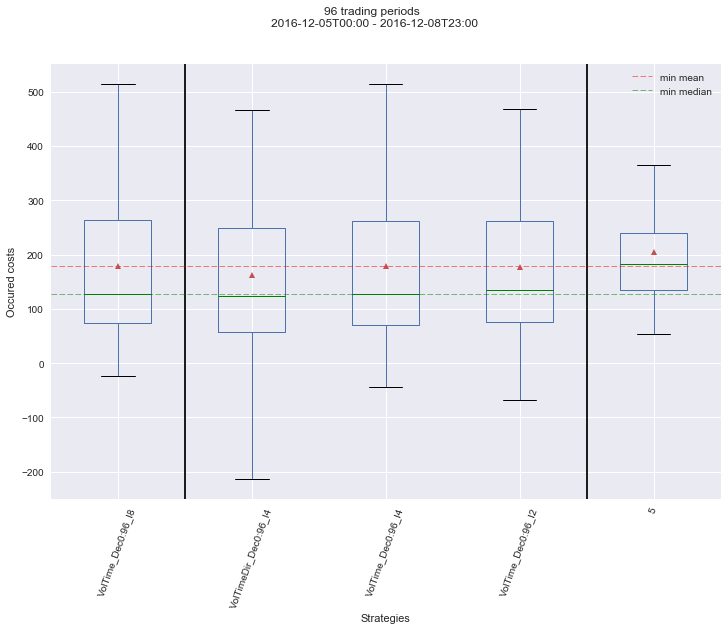

In [177]:
costs = None
baseline = 'VolTime_Dec0:96_I8'
costs, slippage = evaluate(
    testdata=data_dec[96:192],
    agents=agent_collection,
    baseline=baseline,
    evaluate_actions=[5],
    costs=costs,
    verbose=False
)

# display(costs.describe())
# plot_evaluation_costs(costs, hline=baseline)
display(slippage.describe())
plot_evaluation_costs(slippage, hline=baseline)

In [182]:
slippage

,VolTime_Dec0:96_I8,VolTimeDir_Dec0:96_I4,VolTime_Dec0:96_I4,VolTime_Dec0:96_I2,5
2016-12-05T00:00,221.235048,211.324945,232.632411,236.823537,196.930171
2016-12-05T01:00,50.684955,39.194527,50.684955,38.449048,106.608021
2016-12-05T02:00,65.031011,51.708319,65.031011,65.031011,116.101261
2016-12-05T03:00,0.851095,0.851095,0.851095,0.851095,87.134755
2016-12-05T04:00,66.266847,66.089533,66.266847,66.266847,69.796487
2016-12-05T05:00,153.990209,13.059826,149.183000,149.183000,145.779571
2016-12-05T06:00,131.114083,131.114083,131.114083,131.114083,215.418961
2016-12-05T07:00,145.095991,144.882646,138.800884,138.800884,176.349544
2016-12-05T08:00,99.392973,94.484995,94.484995,94.484995,131.069343
2016-12-05T09:00,128.132758,128.132758,128.132758,293.130897,78.793177


60
60


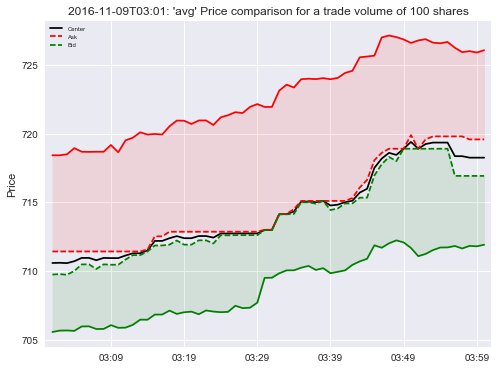

In [159]:
plot_episode(data_dec[62], limits=[765.527563, 767.819562, 769.347561, 770.875560], consume='volume', volume=100)
#plot_episode(data_dec[62], limits=[765.527563, 767.819562, 769.347561, 770.875560], consume='cash', volume=70000)

(96, 5)


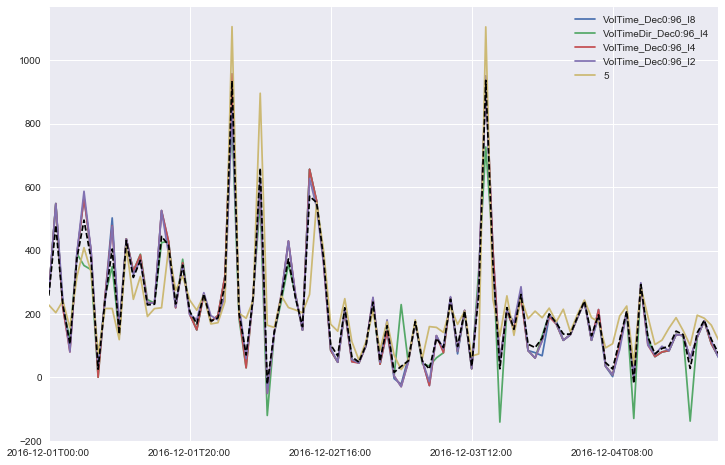

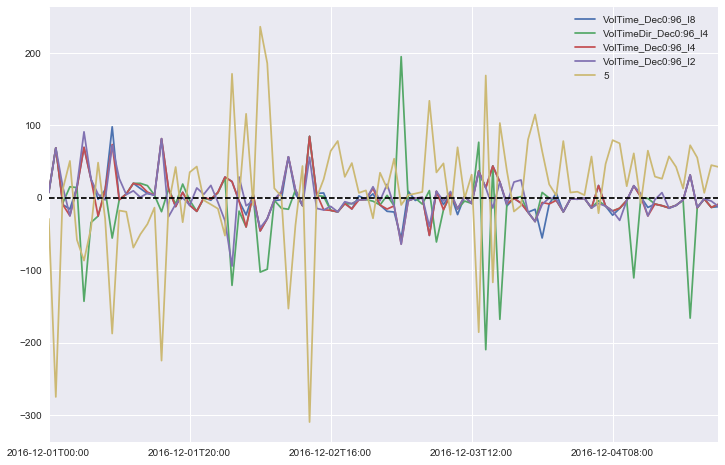

In [176]:
start = 0
end = 100

print(slippage.shape)
slippage.iloc[start:end,:].plot(figsize=(12,8))
plt.plot(slippage.iloc[start:end,:].mean(axis=1).values, color='black', linestyle='--')

tmp = slippage.subtract(slippage.mean(axis=1).values, axis=0)
tmp.iloc[start:end,:].plot(figsize=(12,8))
plt.plot(tmp.iloc[start:end,:].mean(axis=1).values, color='black', linestyle='--')

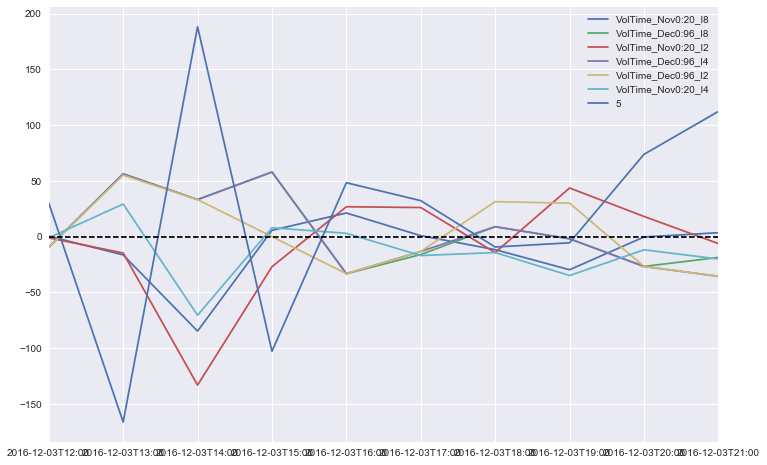

In [ ]:
name = '1611-1701_USDTBTC_Qtable_100vol10_60T4'

modelpath = os.path.join("../Runs/evaluation/models/{}.json".format(name))
ql = QLearn.load(infile=modelpath)
ql.plot_Q(z_represents="action")
ql.plot_Q(z_represents="Q")
ql.heatmap_Q()

In [ ]:
ql = QLearn.load(infile=modelpath)

T = ql.T
V = ql.V
period_length = ql.period_length
actions = ql.actions

filename_train = '/home/axel/data/obs_2016-12_USDT_BTC_range1.2.dict'
filename_test = '/home/axel/data/obs_2017-02_USDT_BTC_range1.2.dict'

episodes_train = OrderbookEpisodesGenerator(filename=filename_train, episode_length=T*period_length)
print("Length of episodes_train: {}".format(len(episodes_train)))

episodes_test = OrderbookEpisodesGenerator(filename=filename_test, episode_length=T*period_length)
print("Length of episodes_test: {}".format(len(episodes_test)))

In [ ]:
def plot_experiment_results(experiments, name=None, ylim=None, showfliers=False, hline=None):
    assert isinstance(hline, str) or hline is None
    
    experiments.plot.box(showmeans=True, color={'medians':'green'}, figsize=(12, 8), showfliers=showfliers)

    plt.axvline(2.5, color='black')
    plt.axvline(3.5, color='black')
    plt.axhline(0, color='black')
    
    if hline is not None:
        plt.axhline(experiments[hline].mean(), color='red', alpha=0.5, linewidth=2, linestyle='--', label='min mean')
        plt.axhline(experiments[hline].median(), color='green', alpha=0.5, linewidth=2, linestyle='--', label='min median')
    
    title = "{} samples  \n{} - {}".format(len(experiments), experiments.index[0], experiments.index[-1])
    if name is not None:
        title = "{}: {}".format(name, title)
    print(title)
    #plt.suptitle(title)
    plt.xlabel("Strategies")
    plt.ylabel("Occured costs")
    plt.savefig("boxplot_train.pdf")
    plt.xticks(rotation=70)
    if ylim is not None:
        plt.ylim(ylim)    
    plt.legend(loc='best')
    
    plt.show()

In [ ]:
def run_Q(V, H, T, ql, episode_windows, actions, costs=None):
    costs = pd.DataFrame([])
    period_length = int(H/T)

    for e, episode in tqdm(enumerate(episode_windows)):
        index = episode[0].timestamp
        
        volume = V
        
        ## Learned strategy
        ots = OrderbookTradingSimulator(orderbooks=episode, volume=volume, tradingperiods=T,
                                         period_length=period_length)
        for tt in range(1, T+1, 1)[::-1]:
            new_vol = round_custombase(ots.volume, base=ql.vol_intervals)  
        
            if new_vol > 0:
                idx = (T-tt)*period_length
                state = ql.state_as_string(time_left=tt, volume_left=new_vol/V)
                # print(idx, state)
                action = ql.chooseAction(state)
        
                # print(state, action)
                obs = episode[period_length * (T-tt)].copy()
                # obs = [elem.copy() for elem in obs_]
            
                ask = obs.get_ask()
                # center = ots.masterbook.get_center()
                limit = ask * (1. + (action/100.))
            else:
                # theoreticall done
                limit == None
            ots.trade(limit = limit, extrainfo={'ACTION':action})
        costs.loc[index, 'Learned_1611-1701'] = ots.history.cost.sum()

    
        ## market order
        ots = OrderbookTradingSimulator(orderbooks=episode, volume=volume, tradingperiods=T,
                                        period_length=period_length)
        ots.trade(limit = None)
        costs.loc[index, 'Market'] = ots.history.cost.sum()
        
        # for a in actions:
        a = 0.4
        lim = episode[0].get_ask() * (1. + (a/100.))
        # print("\n### Fixed limit at: {} (ASK+4) ###".format(lim))
        ots = OrderbookTradingSimulator(orderbooks=episode, volume=volume, tradingperiods=1,
                                        period_length=period_length*T)
        ots.trade(limit = lim)
        key = 'ask*{:1.3f}'.format((1. + (a/100.)))
        costs.loc[index, key] = ots.history.cost.sum()

        
        if e%5==0 or e==len(episode_windows)-1:
            display.clear_output(wait=True)
            plot_experiment_results(costs, name='Testset (USDT-BTC, Feb 2017):')
            
            # costs.to_csv("../Runs/evaluation/Evaluation_obs_TESTSET_2016-12_USDT_BTC_LEARNED_.csv")
            mean = costs.mean()
            print(mean)
            print("Minimal costs reached by S&L strategy: '{}': {:1.4f}".format(mean.argmin(), mean.min()))
        
    return costs

## Check for best S&L Strategy over training data (Nov16-Jan17)

In [ ]:
costs_list_train = pd.concat([
    pd.read_csv("../Runs/evaluation/Evaluation_obs_TRAINSET_2016-11_USDT_BTC.csv", index_col=0),
    pd.read_csv("../Runs/evaluation/Evaluation_obs_TRAINSET_2016-12_USDT_BTC.csv", index_col=0),
    pd.read_csv("../Runs/evaluation/Evaluation_obs_TRAINSET_2017-01_USDT_BTC.csv", index_col=0)])

plot_experiment_results(costs_list_train, name='Trainset (USDT-BTC)', ylim=(-1.5, 1.5))

mean = costs_list_train.mean()
print("Minimal costs reached by S&L strategy: '{}': {:1.4f}".format(mean.argmin(), mean.min()))

### Compare strategies on Testset (Feb2017)

In [ ]:
T = ql.T
V = ql.V
period_length = ql.period_length
print("V={}, T={}, period_length={}".format(V, T, period_length))

costs_list = run_Q(V=100, H=T*period_length, T=T, ql=ql,
                   episode_windows=episodes_test[:5], actions=actions)

In [ ]:
plot_experiment_results(costs_list, name='Trainset (USDT-BTC)')  #, ylim=(-1.5, 1.5))
mean = costs_list_train.mean()
print("Minimal costs reached by S&L strategy: '{}': {:1.4f}".format(mean.argmin(), mean.min()))